### Objective:
-  <b>classify the news categories</b>.

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers ,Sequential
import nltk
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
stop=nltk.corpus.stopwords.words('english')
import warnings
warnings.filterwarnings('ignore')

In [5]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 27.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import spacy
nlp=spacy.load('en_core_web_lg')

## Load Dataset

In [8]:
df=pd.read_json('Dataset.json',lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


## EDA

### Distribution of categories


In [9]:
df['category'].nunique()

41

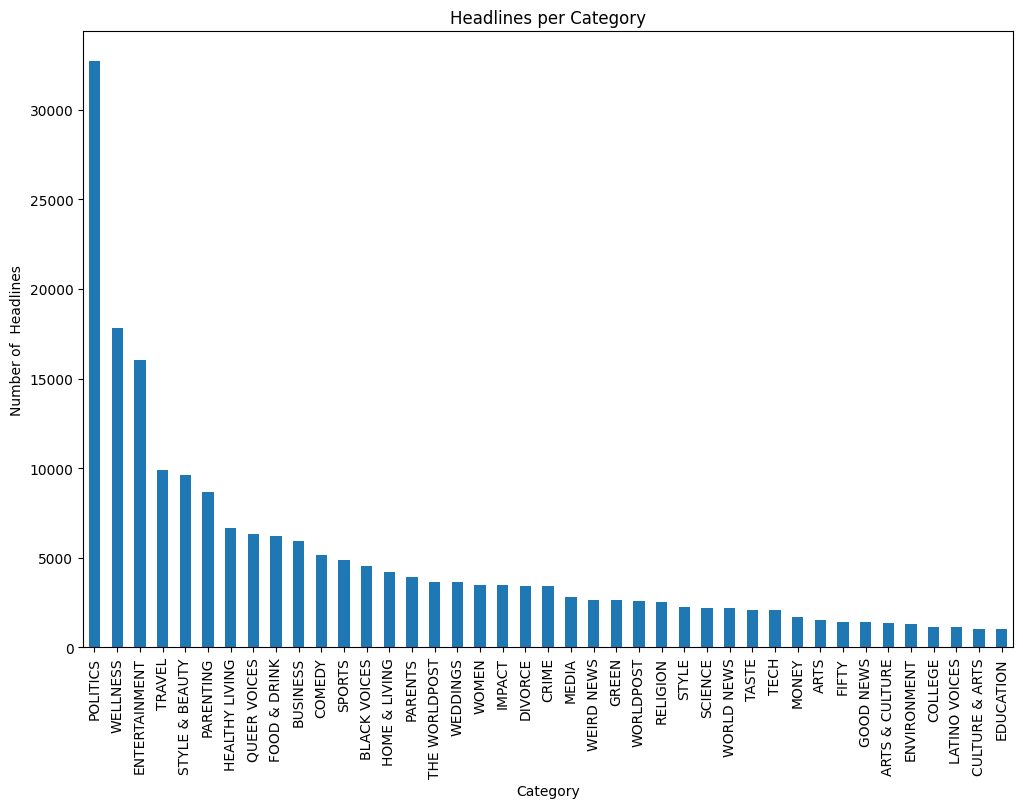

In [10]:
plt.figure(figsize=(12, 8))
df['category'].value_counts().plot(kind='bar')
plt.title("Headlines per Category")
plt.xlabel("Category")
plt.ylabel("Number of  Headlines")
plt.show()

### Text length

In [11]:
df['description_length']=df['short_description'].apply(lambda x: len(x.split()) )
df['headline_lengh']=df['headline'].apply(lambda x: len(x.split()) )

#### Max length for each class

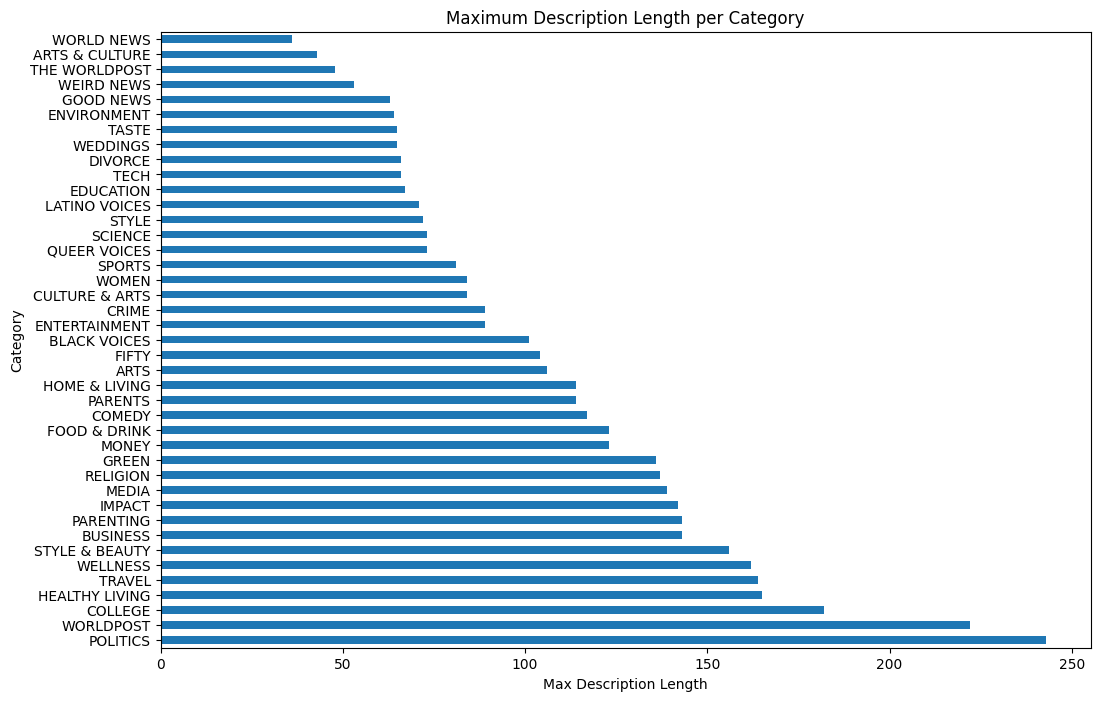

In [12]:
plt.figure(figsize=(12, 8))
df.groupby('category')['description_length'].max().sort_values(ascending=False).plot(kind='barh')
plt.title("Maximum Description Length per Category")
plt.ylabel("Category")
plt.xlabel("Max Description Length")
plt.show()


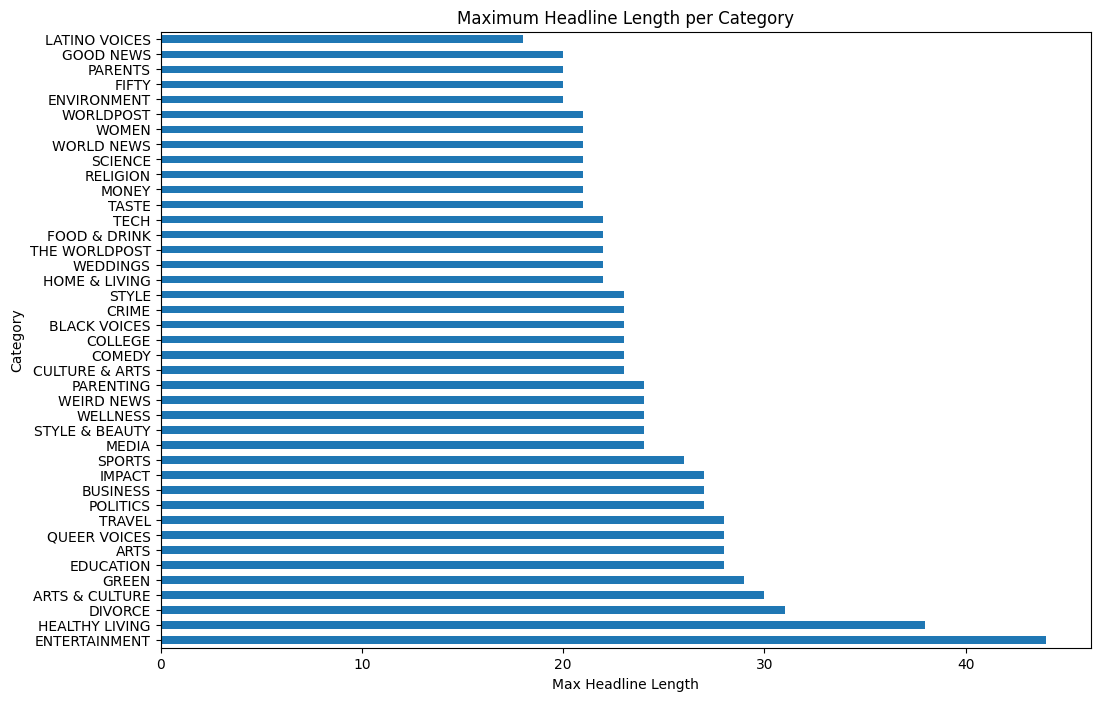

In [13]:
plt.figure(figsize=(12, 8))
df.groupby('category')['headline_lengh'].max().sort_values(ascending=False).plot(kind='barh')
plt.title("Maximum Headline Length per Category")
plt.ylabel("Category")
plt.xlabel("Max Headline Length")
plt.show()


### Top Ten most frequent words per category


In [14]:
from collections import Counter
from nltk.corpus import stopwords
# remve stop words for more accuracte results
stop = set(stopwords.words('english'))
def get_top_words(text,top=10):
    # print(text)
    text=" ".join(text).lower()
    text=[w for w in text.split() if w not in stop]
    return Counter(text).most_common(top)

In [15]:
df.groupby('category')['short_description'].apply(lambda x :get_top_words(x))

category
ARTS              [(art, 124), (one, 116), (new, 114), (--, 94),...
ARTS & CULTURE    [(new, 69), (book, 43), (artist, 42), (one, 40...
BLACK VOICES      [(black, 573), (new, 197), (people, 196), (one...
BUSINESS          [(new, 431), (--, 354), (one, 332), (people, 2...
COLLEGE           [(college, 161), (students, 137), (university,...
COMEDY            [(like, 240), (one, 209), (new, 146), (night, ...
CRIME             [(police, 328), (said, 184), (one, 135), (peop...
CULTURE & ARTS    [(art, 110), (new, 88), (--, 64), (one, 60), (...
DIVORCE           [(divorce, 820), (--, 372), (one, 317), (like,...
EDUCATION         [(school, 159), (education, 153), (students, 1...
ENTERTAINMENT     [(new, 763), (one, 558), (like, 482), (film, 4...
ENVIRONMENT       [(climate, 110), (week, 92), (animal, 92), (--...
FIFTY             [(--, 172), (one, 165), (time, 132), (like, 13...
FOOD & DRINK      [(--, 482), (one, 425), (like, 380), (food, 37...
GOOD NEWS         [(one, 56), (like, 46

## Cleaning & Preprocessing

In [16]:
# check missing values
df.isnull().sum()

category              0
headline              0
authors               0
link                  0
short_description     0
date                  0
description_length    0
headline_lengh        0
dtype: int64

In [17]:
df['category'].value_counts()

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: c

## Merge overlapping categories  

In [73]:
category_map = {
    'WORLDPOST': 'WORLD NEWS',
    'THE WORLDPOST': 'WORLD NEWS',
    'WORLD NEWS': 'WORLD NEWS',

    'ARTS': 'ARTS & CULTURE',
    'ARTS & CULTURE': 'ARTS & CULTURE',
    'CULTURE & ARTS': 'ARTS & CULTURE',

    'STYLE': 'STYLE & BEAUTY',
    'STYLE & BEAUTY': 'STYLE & BEAUTY',

    'PARENTING': 'PARENTING',
    'PARENTS': 'PARENTING',

    'HEALTHY LIVING': 'WELLNESS',
    'WELLNESS': 'WELLNESS',

    'FOOD & DRINK': 'FOOD & DRINK',
    'TASTE': 'FOOD & DRINK',
}

In [74]:
df['category'] = df['category'].replace(category_map)

In [75]:
df['category'].nunique()

33

## Remove all possible redundunt data to ensue data integrity

In [76]:
df['headline'] = df['headline'].str.lower().str.strip()
df['short_description'] = df['short_description'].str.lower().str.strip()

df = df.drop_duplicates(subset=['short_description'],ignore_index=True)
df = df.drop_duplicates(subset=['headline'],ignore_index=True)

In [77]:
df.shape

(177300, 6)

In [78]:
# check duplicates
df['category'].nunique()

33

## Down-Sampling Data to solve data imbalance

In [79]:
min_count=df.groupby('category')['category'].count().min()
min_count

891

In [80]:
balanced_df = df.groupby("category").sample(n=min_count, random_state=42).reset_index(drop=True)

In [81]:
balanced_df.shape

(29403, 6)

In [82]:
balanced_df

,category,headline,authors,link,short_description,date
0,ARTS & CULTURE,william burroughs documentary: howard brookner...,Kathleen Massara,https://www.huffingtonpost.com/entry/restorati...,ab: he was a loving paternal figure to me as a...,2012-12-01
1,ARTS & CULTURE,"bad news, language pedants: poll shows most pe...",Maddie Crum,https://www.huffingtonpost.com/entry/improper-...,"when it comes to texts and emails, rules need ...",2016-05-10
2,ARTS & CULTURE,"phew, those famous white streaks on 'the screa...",Katherine Brooks,https://www.huffingtonpost.com/entry/the-screa...,thanks to some scientists at the university of...,2016-08-31
3,ARTS & CULTURE,the one book you need to read to understand th...,Claire Fallon,https://www.huffingtonpost.com/entry/the-refug...,in nine psychologically evocative short storie...,2017-02-20
4,ARTS & CULTURE,why you need painting to say that painting is ...,"Marc Trujillo, ContributorTRUJILLOMARCART on I...",https://www.huffingtonpost.com/entry/why-you-n...,"i'm a painter, so of course i find statements ...",2014-08-11
...,...,...,...,...,...,...
29398,WORLD NEWS,"leading german far-right figure ditches party,...",Willa Frej,https://www.huffingtonpost.com/entry/germany-a...,the nationalist alternative for germany party ...,2018-01-24
29399,WORLD NEWS,an open letter to the mothers of aleppo,"Myiea Coy, ContributorWriter/ Producer lover o...",https://www.huffingtonpost.com/entry/a-open-le...,"to my fellow carriers of life, first, let me s...",2016-12-16
29400,WORLD NEWS,greek authorities prepare to evacuate crowded ...,"Alexandros Kalafatis, HuffPost Greece",https://www.huffingtonpost.com/entry/greece-ev...,they say they can no longer meet the needs of ...,2016-04-04
29401,WORLD NEWS,erdogan spokesman: germany supports group behi...,"Ece Toksabay, Reuters",https://www.huffingtonpost.com/entry/erdogan-s...,germany and turkey have been locked in a deepe...,2017-03-19


In [83]:
balanced_df['text']=balanced_df['headline']+'.'+balanced_df['short_description']

In [84]:
balanced_df['text'][0]

"william burroughs documentary: howard brookner's movie re-released after decades out of print (video).ab: he was a loving paternal figure to me as a kid. i grew up in greenwich village and i was always nearby him. he would"

# Text Preprocessing

In [85]:
# creat tag map between treebank and wordnet
# tree bank : collection of syntactically annotated sentences
tag_map = {
"CC": None, #formatted. conjunction (and, but, or)
'CD': wn.NOUN, # original number (one,two)
'DT': None, # delimiter (a, the)
'EX': wn.ADV, #and my "there" (there)
"FW": None, # foreign word (mea culpa)
"IN": wn.ADV,# preposition/subjunctive conjunction (of, in,by) 
'JJ': [wn.ADJ, wn.ADJ_SAT],# adjective # (yellow)
'JJR': [wn.ADJ, wn.ADJ_SAT], # add, comparator (larger)
"JJS": [wn.ADJ, wn.ADJ_SAT], # add, superlative (wildest)
"LS": None, #list item tag(1,2,One)
'MD': None, # modal (can, should)
'NN': wn.NOUN, #noun, sing. or nugget (llama)
'NNS': wn.NOUN, #noun, plural (Llamas)
"NNP": wn.NOUN, # proper noun, vocals. (IBM)
'NNPS': wn.NOUN, # proper noun, plural (Carolina)
"PDT": [wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)
'POS':None, # end of ownership
'PRP': None, # personal pronoun (I, you, he)
'prp$': None, # possessive pronoun (your, one's)
"RB": wn.ADV, #adv (quickly, never)
'RBR': wn.ADV, # adverb, comparative (faster)
'RBS':wn.ADV,# adverb, superlative (fastest)
'RP': [wn.ADJ, wn.ADJ_SAT], # particle (up, off)
'SYM': None, #symbol, # (+, %, &)
'TO': None, # 'to' (to)
'UH': None, # interjection (uh, oops)
'VB': wn.VERB,# verb base form # (eat)
'VBD': wn.VERB, # verb past tense (eat)
'VBG': wn.VERB, #verb gerund (to eat)
'VBN': wn.VERB, # past participle (eaten)
"VBP": wn.VERB, #non-3sg pres verb (eat)
'VBZ': wn.VERB,# verb зsg pres (egts) 
}

In [86]:
lemma=WordNetLemmatizer()
def get_lemma(text):
    l=[]
    tags=pos_tag(text.split())
    for token,tag in tags:
        try:
             l.append(lemma.lemmatize(token,pos=tag_map[tag][0]))
        except:
            continue
    return l

In [87]:
from termcolor import colored
def cleaning(df):
    """
    - remove empty strings
    - remove duplicates
    """
    # remove empty string
    blanks=[]
    for i ,v in df.itertuples():
        if pd.isna(v) or (isinstance(v, str) and (v.strip() == "")):
            blanks.append(i)
    if blanks:
        df=df.drop(blanks)
        print(f"found {colored(len(blanks),'red')} blanks")
    else:
        print("no blanks found")

    # remove duplicates
    if df.duplicated().sum() !=0:
        print(f"dropped {colored(df.duplicated().sum(),'red')} : values")
        df=df.drop_duplicates()
    else:
        print("no duplicates found")
    return df

In [88]:
import re
import string
def preprocessing(df,col):


    # lowercasing
    df[col]=df[col].apply(lambda x: x.lower())
    # remove emails
    df[col]=df[col].apply(lambda x: re.sub("\S+\@\S+",'',x))
    # remove URls
    df[col]=df[col].apply(lambda x: re.sub("\S+\.\S+",'',x))
    # split quotation marks and words
    # df[col]=df[col].apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    # remove punctations
    df[col]=df[col].apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]',' ',x))
    # remove stopwords
    df[col]=df[col].apply(lambda x :" ".join(t for t in x.lower().split() if t not in stop))
    # remove \n or \t
    df[col]=df[col].apply(lambda x: re.sub('\n|\t',' ',x))
    # remove 2 characters words
    df[col]=df[col].apply(lambda x: re.sub(r' \w\w ',' ',x) )
    # remove 1 character words
    df[col]=df[col].apply(lambda x: re.sub(r' \w ',' ',x) )
    # remove extra spaces more than or equals "2" 
    df[col]=df[col].apply(lambda x: re.sub(" {2,}",' ',x))
    # select alphapetical only
    df[col]=df[col].apply(lambda x: re.sub("[^a-z]+",' ',x) )
    # strip string
    df[col]=df[col].apply(lambda x: x.strip())
    # get lemma
    # df[col]=df[col].apply(lambda x: " ".join(get_lemma(x)))
    return df

In [89]:
x=balanced_df[['text']]
y=balanced_df['category']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)

In [91]:
cleaned_train=cleaning(X_train)
cleaned_test=cleaning(X_test)

no blanks found
no duplicates found
no blanks found
no duplicates found


In [92]:
prep_train=preprocessing(cleaned_train,col='text')
prep_test=preprocessing(cleaned_test,col='text')

In [93]:
y_train=y_train[prep_train.index]
y_test=y_test[prep_test.index]

In [94]:
from sklearn.preprocessing import LabelEncoder

lb=LabelEncoder()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

# Modeling

### Use Tfidf with classical algorithms

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [96]:

clf_nb=Pipeline([ ('tfidf',TfidfVectorizer(ngram_range=(1,3),max_features=30000, stop_words='english')),
                 ('clf',MultinomialNB())
])

clf_svc=Pipeline([ ('tfidf',TfidfVectorizer(ngram_range=(1,3),max_features=30000, stop_words='english')),
                ('clf',LinearSVC())
])

clf_xgb=Pipeline([ ('tfidf',TfidfVectorizer(ngram_range=(1,2),max_features=5000, stop_words='english')),
                ('clf',XGBClassifier())
])

In [97]:
clf_nb.fit(prep_train['text'], y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [98]:
predictions = clf_nb.predict(prep_test['text'])

In [99]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52       178
           1       0.52      0.36      0.42       178
           2       0.47      0.35      0.40       178
           3       0.61      0.53      0.57       178
           4       0.55      0.46      0.50       178
           5       0.49      0.74      0.59       178
           6       0.67      0.72      0.70       179
           7       0.51      0.64      0.57       179
           8       0.43      0.37      0.40       178
           9       0.52      0.46      0.49       178
          10       0.22      0.51      0.31       179
          11       0.63      0.74      0.68       178
          12       0.48      0.39      0.43       178
          13       0.49      0.47      0.48       178
          14       0.62      0.69      0.65       179
          15       0.34      0.37      0.35       178
          16       0.69      0.45      0.54       178
          17       0.59    

In [100]:
clf_svc.fit(prep_train['text'], y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('clf', LinearSVC())])

In [101]:
predictions = clf_svc.predict(prep_test['text'])

In [102]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       178
           1       0.48      0.42      0.45       178
           2       0.38      0.38      0.38       178
           3       0.53      0.54      0.54       178
           4       0.57      0.44      0.50       178
           5       0.57      0.57      0.57       178
           6       0.69      0.72      0.70       179
           7       0.55      0.60      0.58       179
           8       0.38      0.37      0.37       178
           9       0.47      0.46      0.46       178
          10       0.35      0.34      0.34       179
          11       0.58      0.71      0.64       178
          12       0.41      0.32      0.36       178
          13       0.50      0.46      0.48       178
          14       0.60      0.68      0.64       179
          15       0.32      0.30      0.31       178
          16       0.65      0.56      0.60       178
          17       0.59    

### Use Sequences

In [103]:
def get_longest_text(texts):
    longest=0
    for text in texts:
        text_len=len(text.split())
        longest=max(text_len,longest)
    return longest

In [104]:
longest_input=get_longest_text(prep_train['text'])
longest_input

115

In [105]:
max_len=100

In [106]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### Tokenization and padding sequences

In [107]:
tokenizer=Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(prep_train['text'])

In [108]:
vocab_size = len(tokenizer.word_index) + 1

In [109]:
vocab_size

35074

In [110]:
X_train_seq = tokenizer.texts_to_sequences(prep_train['text'])
X_test_seq  = tokenizer.texts_to_sequences(prep_test['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post')

In [111]:
X_train_pad

array([[ 7591, 15379,   216, ...,     0,     0,     0],
       [  353,   930,  1350, ...,     0,     0,     0],
       [ 3725,   245,    50, ...,     0,     0,     0],
       ...,
       [  124,   644,    33, ...,     0,     0,     0],
       [ 4301,  5111, 10327, ...,     0,     0,     0],
       [   98,  6987, 20772, ...,     0,     0,     0]], dtype=int32)

In [112]:
n_classes=len(np.unique(y_train))
n_classes

33

### Use BI-LSTM 

In [136]:
from tensorflow.keras import regularizers
model=Sequential([

    layers.Embedding(input_dim=vocab_size,output_dim=100),
    layers.Bidirectional(layers.LSTM(128,return_sequences=True)),    
    layers.Bidirectional(layers.LSTM(64,return_sequences=True)),    
    layers.Bidirectional(layers.LSTM(32)),    
    # layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

In [137]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [142]:
model.fit(X_train_pad,y_train,validation_data=(X_test_pad,y_test),epochs=10,batch_size=32,verbose=1)

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.8414 - loss: 0.8682 - val_accuracy: 0.3957 - val_loss: 2.7985
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9196 - loss: 0.3525 - val_accuracy: 0.3974 - val_loss: 3.1256
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9589 - loss: 0.1805 - val_accuracy: 0.3845 - val_loss: 3.5369
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9728 - loss: 0.1122 - val_accuracy: 0.3872 - val_loss: 4.0966
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9818 - loss: 0.0740 - val_accuracy: 0.3848 - val_loss: 4.4182
Epoch 6/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9876 - loss: 0.0532 - val_accuracy: 0.3714 - val_loss: 4.9090
Epoch 7/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9902 - loss: 0.0377 - val_accuracy: 0.3766 - val_loss: 5.0686
Epoch 8/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9895 - loss: 0.0363 - 

In [143]:
nlp = spacy.load('en_core_web_md')

In [145]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0

### Enhancement use glove Embedding

In [146]:
vocab_size

35074

In [147]:
print("Creating embedding matrix...")
# Iterate through YOUR tokenizer's vocabulary
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        # SpaCy handles the lookup internally
        token = nlp(word)
        
        # Check if the word has a vector (is not a rare OOV word)
        if token.has_vector:
            embedding_matrix[i] = token.vector
            hits += 1
        else:
            misses += 1

print(f"Converted {hits} words. Missed {misses} words.")

Creating embedding matrix...
Converted 32503 words. Missed 2570 words.


In [165]:
from tensorflow.keras import regularizers
model2=Sequential([

    layers.Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix],trainable=False),
    layers.Bidirectional(layers.LSTM(128,return_sequences=False, recurrent_dropout=0.3)),    
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

In [166]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [167]:
model2.fit(X_train_pad,y_train,validation_split=0.2,epochs=10,batch_size=32,verbose=1)

Epoch 1/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.1877 - loss: 2.9834 - val_accuracy: 0.3747 - val_loss: 2.2505
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 182s 309ms/step - accuracy: 0.3738 - loss: 2.2105 - val_accuracy: 0.4170 - val_loss: 2.0887
Epoch 3/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 180s 306ms/step - accuracy: 0.4391 - loss: 1.9735 - val_accuracy: 0.4223 - val_loss: 2.0356
Epoch 4/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 181s 307ms/step - accuracy: 0.4718 - loss: 1.8426 - val_accuracy: 0.4325 - val_loss: 2.0129
Epoch 5/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 182s 308ms/step - accuracy: 0.5065 - loss: 1.7109 - val_accuracy: 0.4404 - val_loss: 2.0105
Epoch 6/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 181s 307ms/step - accuracy: 0.5365 - loss: 1.6016 - val_accuracy: 0.4397 - val_loss: 1.9994
Epoch 7/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 181s 307ms/step - accuracy: 0.5643 - loss: 1.4905 - val_accuracy: 0.4465 - val_loss: 2.0317
Epoch 8/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 180s 305ms/step - accuracy: 0.5837 -

### Unfreeze Embeddings

In [171]:
from tensorflow.keras.optimizers import Adam
model2.layers[0].trainable = True

In [172]:
optimizer = Adam(learning_rate=1e-5)
model2.compile(loss='sparse_categorical_crossentropy', 
               optimizer=optimizer, 
               metrics=['accuracy'])

In [173]:
model2.fit(X_train_pad,y_train,validation_split=0.2,epochs=10,batch_size=32,verbose=1)

Epoch 1/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 197s 327ms/step - accuracy: 0.6613 - loss: 1.1352 - val_accuracy: 0.4438 - val_loss: 2.1021
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 191s 324ms/step - accuracy: 0.6701 - loss: 1.0961 - val_accuracy: 0.4448 - val_loss: 2.1043
Epoch 3/10
 66/589 ━━━━━━━━━━━━━━━━━━━━ 2:41 308ms/step - accuracy: 0.6648 - loss: 1.0916

KeyboardInterrupt: 

### CNN+LSTM

In [177]:
from tensorflow.keras import regularizers
model_hybrid=Sequential([

    layers.Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix],trainable=False),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Bidirectional(layers.LSTM(128,return_sequences=False, recurrent_dropout=0.1)),    
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

In [178]:
model_hybrid.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
model_hybrid.fit(X_train_pad,y_train,validation_split=0.2,epochs=10,batch_size=32,verbose=1)

Epoch 1/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 104s 165ms/step - accuracy: 0.1834 - loss: 2.9839 - val_accuracy: 0.3498 - val_loss: 2.3165
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - accuracy: 0.4045 - loss: 2.0928 - val_accuracy: 0.3849 - val_loss: 2.1785
Epoch 3/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 97s 164ms/step - accuracy: 0.4900 - loss: 1.7807 - val_accuracy: 0.4098 - val_loss: 2.1231
Epoch 4/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - accuracy: 0.5737 - loss: 1.4585 - val_accuracy: 0.3998 - val_loss: 2.2048
Epoch 5/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 97s 164ms/step - accuracy: 0.6398 - loss: 1.2022 - val_accuracy: 0.3991 - val_loss: 2.3408
Epoch 6/10
415/589 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.7446 - loss: 0.8621

KeyboardInterrupt: 

In [182]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

model_avg = Sequential([
    # 1. Pre-trained Embeddings (FROZEN)
    # We use the SpaCy/GloVe matrix you created
    layers.Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix],trainable=False),
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(n_classes, activation='softmax')
])

model_avg.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [185]:
model_avg.fit(
    X_train_pad, y_train, 
    validation_split=0.2, 
    epochs=50,              # This model trains very fast, so we can do more epochs
    batch_size=32, 
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4589 - loss: 1.8719 - val_accuracy: 0.4206 - val_loss: 2.0635 - learning_rate: 1.0000e-05
Epoch 2/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4691 - loss: 1.8636 - val_accuracy: 0.4206 - val_loss: 2.0634 - learning_rate: 1.0000e-05
Epoch 3/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4648 - loss: 1.8755 - val_accuracy: 0.4200 - val_loss: 2.0634 - learning_rate: 1.0000e-05
Epoch 4/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4586 - loss: 1.8842 - val_accuracy: 0.4198 - val_loss: 2.0634 - learning_rate: 1.0000e-05
Epoch 5/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4663 - loss: 1.8691 - val_accuracy: 0.4202 - val_loss: 2.0636 - learning_rate: 1.0000e-05
Epoch 6/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4645 - loss: 1.8666 - val_accuracy: 0.4198 - val_loss: 2.0636 - learning_rate: 1.0000e-05
Epoch 7/50
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 

# It is Bert Time

In [186]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [187]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [213]:
cleaned_train['text'][0]

'william burroughs documentary howard brookner movie released decades print loving paternal figure kid grew greenwich village always nearby would'

In [215]:
print("Tokenizing data... (this may take a moment)")
train_encodings = tokenizer(list(cleaned_train['text']), truncation=True, padding=True, )
test_encodings = tokenizer(list(cleaned_test['text']), truncation=True, padding=True)

Tokenizing data... (this may take a moment)


In [216]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(16) # BERT uses smaller batch sizes usually

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

In [219]:
len(pd.unique(y_train))

33

In [220]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=33
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [221]:
from transformers import create_optimizer
import tensorflow as tf

# 1. Calculate Training Steps
# BERT needs to know how long it will train to adjust the learning rate
batch_size = 16
num_epochs = 5
batches_per_epoch = len(train_dataset) 
total_train_steps = int(batches_per_epoch * num_epochs)

# 2. Create the Optimizer using Hugging Face's tool
# This creates a version-compatible optimizer automatically
optimizer, schedule = create_optimizer(
    init_lr=3e-5,                # The ideal learning rate for BERT
    num_warmup_steps=0,          # Optional: Warmup steps
    num_train_steps=total_train_steps
)

# 3. Compile
# We do not pass a loss function here because HuggingFace models 
# calculate loss internally if you don't specify it.
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [222]:
# 4. Train
print("Starting BERT training...")
history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=num_epochs
)

Starting BERT training...
Epoch 1/5
1471/1471 [==============================] - 234s 147ms/step - loss: 1.9864 - accuracy: 0.4889 - val_loss: 1.5167 - val_accuracy: 0.5800
Epoch 2/5
1471/1471 [==============================] - 213s 145ms/step - loss: 1.2061 - accuracy: 0.6709 - val_loss: 1.5016 - val_accuracy: 0.5897
Epoch 3/5
1471/1471 [==============================] - 213s 145ms/step - loss: 0.8432 - accuracy: 0.7720 - val_loss: 1.5294 - val_accuracy: 0.5853
Epoch 4/5
1471/1471 [==============================] - 213s 145ms/step - loss: 0.5871 - accuracy: 0.8471 - val_loss: 1.5979 - val_accuracy: 0.5860
Epoch 5/5
1471/1471 [==============================] - 213s 145ms/step - loss: 0.4382 - accuracy: 0.8887 - val_loss: 1.6386 - val_accuracy: 0.5854


**Bert got the highest 58% for 33 class**